# Data Augmentation

In [8]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear  
# inline in the notebook rather than in a new window.
%matplotlib inline

# set default size of plots
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np

In [10]:
# path to the input image
image = './datasets/images/panamera.jpg'
# path to output directory to store augmentation examples
output = './output/data-augmentation'
# output filename prefix
prefix = 'image'

In [11]:
# load the input image, convert it to a NumPy array, and then
# reshape it to have an extra dimension
print("[INFO] loading example image...")
image = load_img(image)
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

[INFO] loading example image...


In [12]:
# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")
total = 0

In [6]:
# construct the actual Python generator
print("[INFO] generating images...")
imageGen = aug.flow(image, batch_size=1, save_to_dir=output, save_prefix=prefix, save_format="jpg")

# loop over examples from our image data augmentation generator
for image in imageGen:
    # increment our counter
    total += 1

    # if we have reached 10 examples, break from the loop
    if total == 10:
        break

[INFO] generating images...


# Data Augmentation MiniVGG CIFAR10

In [13]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# load the training and testing data, scale it into the range [0, 1],
# then reshape the design matrix
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

[INFO] loading CIFAR-10 data...


In [15]:
# convert the labels from integers to vectors
labelBinarizer = LabelBinarizer()
trainY = labelBinarizer.fit_transform(trainY)
testY = labelBinarizer.fit_transform(testY)

In [16]:
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from classifiers.mini_vgg import MiniVGGNet

In [18]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [19]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.05)
miniVGG = MiniVGGNet()
model = miniVGG.build(width=32, height=32, depth=3, classes=len(labelNames))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [14]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=64), 
                        validation_data=(testX, testY), steps_per_epoch=len(trainX)//64,
                        epochs=40, verbose=1)

[INFO] training network...
Epoch 1/40
781/781 [==============================] - 19s 24ms/step - loss: 1.8497 - acc: 0.3774 - val_loss: 1.3753 - val_acc: 0.5106
Epoch 2/40
781/781 [==============================] - 18s 23ms/step - loss: 1.4885 - acc: 0.4704 - val_loss: 1.2008 - val_acc: 0.5661
Epoch 3/40
781/781 [==============================] - 18s 23ms/step - loss: 1.3550 - acc: 0.5175 - val_loss: 1.3633 - val_acc: 0.5469
Epoch 4/40
781/781 [==============================] - 18s 23ms/step - loss: 1.2756 - acc: 0.5486 - val_loss: 0.9969 - val_acc: 0.6533
Epoch 5/40
781/781 [==============================] - 18s 23ms/step - loss: 1.2097 - acc: 0.5705 - val_loss: 1.3112 - val_acc: 0.5907
Epoch 6/40
781/781 [==============================] - 18s 23ms/step - loss: 1.1492 - acc: 0.5910 - val_loss: 1.0019 - val_acc: 0.6592
Epoch 7/40
781/781 [==============================] - 18s 23ms/step - loss: 1.1092 - acc: 0.6062 - val_loss: 0.9483 - val_acc: 0.6758
Epoch 8/40
781/781 [===============

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.88      0.73      0.80      1000
  automobile       0.87      0.90      0.88      1000
        bird       0.84      0.59      0.69      1000
         cat       0.76      0.53      0.63      1000
        deer       0.83      0.66      0.73      1000
         dog       0.78      0.67      0.72      1000
        frog       0.59      0.95      0.73      1000
       horse       0.81      0.86      0.84      1000
        ship       0.92      0.87      0.90      1000
       truck       0.66      0.96      0.78      1000

    accuracy                           0.77     10000
   macro avg       0.79      0.77      0.77     10000
weighted avg       0.79      0.77      0.77     10000



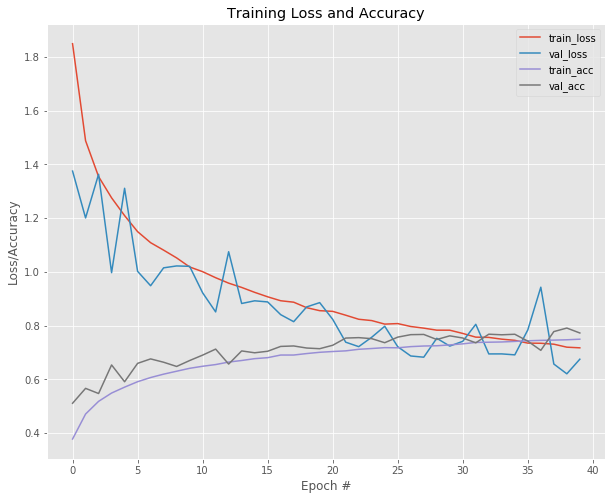

In [15]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Well Done